In [8]:
from scipy.io import loadmat
import numpy as np
from matplotlib import pyplot as plt

X = loadmat("BreastCancer.mat")['X']
y = loadmat("BreastCancer.mat")['y']

## Q1

In [2]:
def ista_solve_hot( A, d, la_array ):
    # ista_solve_hot: Iterative soft-thresholding for multiple values of
    # lambda with hot start for each case - the converged value for the previous
    # value of lambda is used as an initial condition for the current lambda.
    # this function solves the minimization problem
    # Minimize |Ax-d|_2^2 + lambda*|x|_1 (Lasso regression)
    # using iterative soft-thresholding.
    max_iter = 10**4
    tol = 10**(-3)
    tau = 1/np.linalg.norm(A,2)**2
    n = A.shape[1]
    w = np.zeros((n,1))
    num_lam = len(la_array)
    X = np.zeros((n, num_lam))
    for i, each_lambda in enumerate(la_array):
        for j in range(max_iter):
            z = w - tau*(A.T@(A@w-d))
            w_old = w
            w = np.sign(z) * np.clip(np.abs(z)-tau*each_lambda/2, 0, np.inf)
            X[:, i:i+1] = w
            if np.linalg.norm(w - w_old) < tol:
                break
    return X

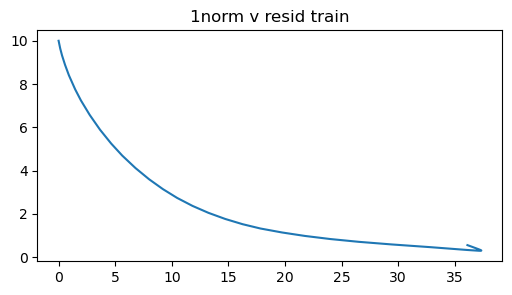

In [3]:
Atr = X[:100, :]
btr = y[:100, :]

Ate = X[100:, :]
bte = y[100:, :]

lam = np.logspace(-6, 2, num=80) #define lambdas
num = lam.shape[0]
W = ista_solve_hot(Atr,btr,lam)

err=[]
res=[]
norm=[]
nonzer=[]
errv=[]
resv=[]
for i in range(num):
    err.append(np.mean(np.sign(Atr@W[:,i:i+1]) != btr))
    res.append(np.linalg.norm(Atr@W[:,i:i+1]-btr))
    norm.append(np.linalg.norm(W[:,i],1))
    nonzer.append(np.sum(abs(W[:,i])>1e-6))
    errv.append(np.mean(np.sign(Ate@W[:,i:i+1]) != bte))
    resv.append(np.linalg.norm(Ate@W[:,i:i+1]-bte))
    
#1A
plt.figure(figsize=(6,3))
plt.plot(norm, res)
plt.title("1norm v resid train")
plt.show()
#the higher the 1-norm value, the lower the training residuals are

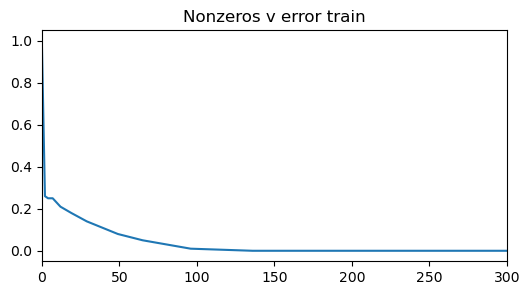

In [4]:
#1B
plt.figure(figsize=(6,3))
plt.plot(nonzer, err)
plt.xlim([0,300])
plt.title("Nonzeros v error train")
plt.show()

err_rate = [err[i] for i in range(num)]
total_pred = btr.shape[0]
err_rate = [err[i] / total_pred for i in range(num)]

# The lower the error rates the lower the sparsity is

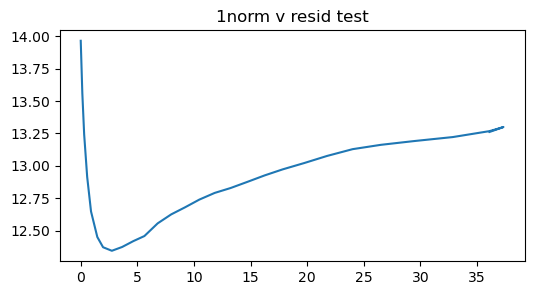

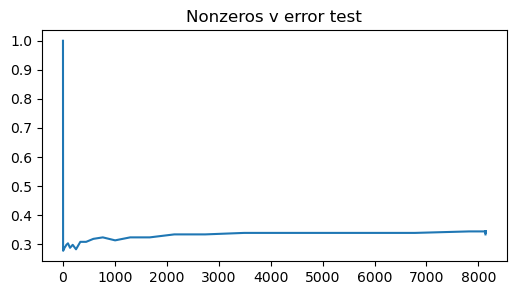

In [5]:
#1C
plt.figure(figsize=(6,3))
plt.plot(norm, resv)
plt.title("1norm v resid test")
plt.show()
#Like with the training daata, the higher the 1-norm value the lower the residuals are

plt.figure(figsize=(6,3))
plt.plot(nonzer, errv)
plt.title("Nonzeros v error test")
plt.show()
#the lowest error is not when we have all the variables with nonzero weights, but
#actually when only very few vars have meaningful weights, under 300 vars I would say

## Q2

In [6]:
##LASSO

lam = np.logspace(-6,4,num=100)
num=lam.shape[0]

# each row of setindices denotes the starting an ending index for one
# partition of the data: 5 sets of 30 samples and 5 sets of 29 samples
setindices = [[1,30],[31,60],[61,90],[91,120],[121,150],[151,179],[180,208],[209,237],[238,266],[267,295]]

# each row of holdoutindices denotes the partitions that are held out from
# the training set
holdoutindices = [[1,2],[2,3],[3,4],[4,5],[5,6],[7,8],[9,10],[10,1]]

cases = len(holdoutindices)

# be sure to initiate the quantities you want to measure before looping
# through the various training, validation, and test partitions
index = np.asarray(range(295))
errv2_l1 = np.zeros(cases)
resv2_l1 = np.zeros(cases)

# Loop over various cases
for j in range(cases):
    # row indices of first validation set
    v1_ind = np.arange(setindices[holdoutindices[j][0]-1][0]-1,setindices[holdoutindices[j][0]-1][1])
    
    # row indices of second validation set
    v2_ind = np.arange(setindices[holdoutindices[j][1]-1][0]-1,setindices[holdoutindices[j][1]-1][1])
    
    # row indices of training set
    trn_ind = list(set(range(295))-set(v1_ind)-set(v2_ind))
    
    # define matrix of features and labels corresponding to first
    # validation set
    Av1 = X[v1_ind,:]
    bv1 = y[v1_ind]
    
    # define matrix of features and labels corresponding to second
    # validation set
    Av2 = X[v2_ind,:]
    bv2 = y[v2_ind]
    
    # define matrix of features and labels corresponding to the 
    # training set
    At = X[trn_ind,:]
    bt = y[trn_ind]
    
    #print(len(v1_ind), len(v2_ind), len(trn_ind))
    
    # Use training data to learn classifier
    W = ista_solve_hot(At, bt, lam)
    errv2 = np.zeros(num)

    for i in range(num):
        errv2[i] = np.mean(np.sign(Av1 @ W[:, i:i+1]) != bv1)
    min_ind = np.argmin(errv2)
    errv2_l1[j] = np.mean(np.sign(Av2 @ W[:, min_ind:min_ind+1]) != bv2)
    resv2_l1[j] = np.linalg.norm(Av2 @ W[:, min_ind:min_ind+1] - bv2) ** 2


# Find best lambda value using first validation set, then evaluate
# performance on second validation set, and accumulate performance metrics
# over all cases partitions

#Avgs
print("Error rate:", np.mean(errv2_l1))
print("SE:", np.mean(resv2_l1))

Error rate: 0.3165229885057471
SE: 25.468802901706447


In [7]:
##RIDGE

lam = np.logspace(-6,6,num=100)
num=lam.shape[0]

# each row of setindices denotes the starting an ending index for one
# partition of the data: 5 sets of 30 samples and 5 sets of 29 samples
setindices = [[1,30],[31,60],[61,90],[91,120],[121,150],[151,179],[180,208],[209,237],[238,266],[267,295]]

# each row of holdoutindices denotes the partitions that are held out from
# the training set
holdoutindices = [[1,2],[2,3],[3,4],[4,5],[5,6],[7,8],[9,10],[10,1]]

cases = len(holdoutindices)

# be sure to initiate the quantities you want to measure before looping
# through the various training, validation, and test partitions
index = np.asarray(range(295))
errv2_l2 = np.zeros(cases)
resv2_l2 = np.zeros(cases)

# Loop over various cases
for j in range(cases):
    # row indices of first validation set
    v1_ind = np.arange(setindices[holdoutindices[j][0]-1][0]-1,setindices[holdoutindices[j][0]-1][1])
    
    # row indices of second validation set
    v2_ind = np.arange(setindices[holdoutindices[j][1]-1][0]-1,setindices[holdoutindices[j][1]-1][1])
    
    # row indices of training set
    trn_ind = list(set(range(295))-set(v1_ind)-set(v2_ind))
    
    # define matrix of features and labels corresponding to first
    # validation set
    Av1 = X[v1_ind,:]
    bv1 = y[v1_ind]
    
    # define matrix of features and labels corresponding to second
    # validation set
    Av2 = X[v2_ind,:]
    bv2 = y[v2_ind]
    
    # define matrix of features and labels corresponding to the 
    # training set
    At = X[trn_ind,:]
    bt = y[trn_ind]
    
    #print(len(v1_ind), len(v2_ind), len(trn_ind))
    
    # Use training data to learn classifier
    W = np.zeros((At.shape[1], num))
    errv22 = np.zeros(num)

    for i in range(num):
        W[:, i:i+1] = At.T @ np.linalg.inv(At @ At.T + lam[i] * np.eye(At.shape[0])) @ bt
        errv22[i] = np.mean(np.sign(Av1 @ W[:, i:i+1]) != bv1)
    min_ind = np.argmin(errv22)
    errv2_l2[j] = np.mean(np.sign(Av2 @ W[:, min_ind:min_ind+1]) != bv2)
    resv2_l2[j] = np.linalg.norm(Av2 @ W[:, min_ind:min_ind+1] - bv2) ** 2


# Find best lambda value using first validation set, then evaluate
# performance on second validation set, and accumulate performance metrics
# over all cases partitions

#Avgs
print("error rate:", np.mean(errv2_l2))
print("SE:", np.mean(resv2_l2))

error rate: 0.30833333333333335
SE: 24.877500332487998


In [ ]:
## LASSO 10-fold CV another way

# each row of setindices denotes the starting an ending index for one
# partition of the data: 5 sets of 30 samples and 5 sets of 29 samples
setindices = [[1,30],[31,60],[61,90],[91,120],[121,150],[151,179],[180,208],[209,237],[238,266],[267,295]]

# each row of holdoutindices denotes the partitions that are held out from
# the training set
holdoutindices = [[1,2],[2,3],[3,4],[4,5],[5,6],[7,8],[9,10],[10,1]]

cases = len(holdoutindices)

# be sure to initiate the quantities you want to measure before looping
# through the various training, validation, and test partitions
errv1 = np.zeros(N)
errv2_l1 = np.zeros(cases)
resv2_l1 = np.zeros(cases)


# Loop over various cases
for j in range(cases):
    # row indices of first validation set
    v1_ind = np.arange(setindices[holdoutindices[j][0]-1][0]-1,setindices[holdoutindices[j][0]-1][1])
    
    # row indices of second validation set
    v2_ind = np.arange(setindices[holdoutindices[j][1]-1][0]-1,setindices[holdoutindices[j][1]-1][1])
    
    # row indices of training set
    trn_ind = list(set(range(295))-set(v1_ind)-set(v2_ind))
    
    # define matrix of features and labels corresponding to first
    # validation set
    Av1 = X[v1_ind,:]
    bv1 = y[v1_ind]
    
    # define matrix of features and labels corresponding to second
    # validation set
    Av2 = X[v2_ind,:]
    bv2 = y[v2_ind]
    
    # define matrix of features and labels corresponding to the 
    # training set
    At = X[trn_ind,:]
    bt = y[trn_ind]
    
    print(len(v1_ind), len(v2_ind), len(trn_ind))
# Use training data to learn classifier
#   W = ista_solve_hot(At,bt,lam_vals),
    W = ista_solve_hot(At, bt, lam_vals)

    # Evaluate results for Av1
    Bhatv1 = np.sign(Av1.dot(W))
    for i in range(N):
        errv1[i] = np.mean(Bhatv1[:, i] != bv1)

    # Find lambda index with minimum error
    mn_idx = np.argmin(errv1)

    # Evaluate results for Av2 using the lambda with minimum error on Av1
    errv2_l1[j] = np.mean(np.sign(Av2.dot(W[:, mn_idx])) != bv2)
    resv2_l1[j] = np.linalg.norm(Av2.dot(W[:, mn_idx]) - bv2, 2)**2

# Calculate mean error and mean squared error over all cases
err10fold_l1 = np.mean(errv2_l1)
res10fold_l1 = np.mean(resv2_l1)